In [8]:
using GLM, DataFrames, Plots, Distributions, HypothesisTests, StatPlots, Measures, PlotThemes

pyplot()
theme(:wong)
wong = palette(:wong)

slicedims(mat, dim) = broadcast(x -> selectdim(mat, dim, x), 1:size(mat, dim))
ivcat(mat) = slicedims(mat, 1)

ivcat (generic function with 1 method)

# Reading the Data

In [2]:
fn_tabs(str) = count(x -> x == '\t', str)

file = readchomp("data.txt");
lines = split(file, "\n");
filter!(l -> length(strip(l)) > 0, lines);
indent_lines = map(l -> (fn_tabs(l), strip(l)), lines);

function hierarch(indent_lines)
    inds = findall(i_l -> i_l[1] == indent_lines[1][1], indent_lines)
    ends = [inds[2:end]; length(indent_lines) + 1]

    if length(inds) == length(indent_lines)
        return map(i_l -> map(x -> parse(Float64, x), split(i_l[2])), indent_lines)
    end

    d = Dict()
    for (i, e) in zip(inds, ends)
        d[indent_lines[i][2]] = hierarch(indent_lines[i+1:e-1])
    end

    return d
end

data = hierarch(indent_lines)

Dict{Any,Any} with 4 entries:
  "Gyro"       => Array{Float64,1}[[0.0, 2.0, 4.0, 2.0, 3.0, 4.0], [45.0, 47.0,…
  "Motor"      => Dict{Any,Any}("Rotational"=>Array{Float64,1}[[25.0, 50.0, 56.…
  "Ultrasonic" => Array{Float64,1}[[1.0, 3.0, 3.0, 3.2, 2.8, 3.2], [2.0, 3.0, 3…
  "Color"      => Dict{Any,Any}("Light"=>Dict{Any,Any}("Yellow"=>Array{Float64,…

# Sensor Calibration Plots 

In [9]:
function linefit(data, title)
    ols = lm(@formula(Sensor ~ Actual), data)
    intercept, slope = coef(ols)
    
    scatter(data[:Actual], data[:Sensor], title=title,
        xlabel="Actual", ylabel="Sensor", label="Data", m=(0.2, :x, 7), c=[wong[1]])

    plot!(x -> intercept + slope * x, [minimum(data[:Actual]), maximum(data[:Actual])],
        label="Fit: y = $(round(intercept, digits=3)) +" *
        "$(round(slope, digits=3))⋅x")
end

linefit (generic function with 1 method)

# Ultrasonic Sensor

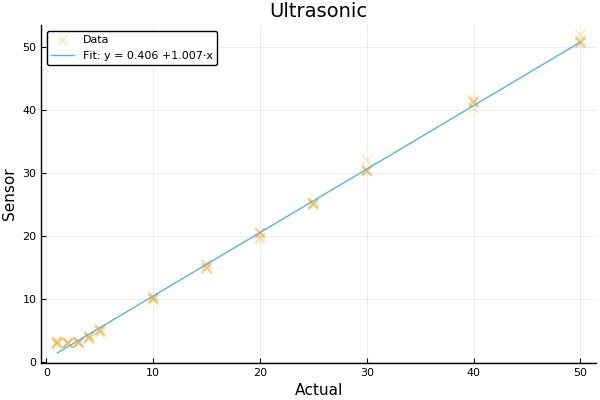

In [10]:
ultrasonic_data = DataFrame(
    vcat(([row[1] measured] for row in data["Ultrasonic"] for measured in row[2:end])...), [:Actual, :Sensor])

linefit(ultrasonic_data, "Ultrasonic")

# Light - Color Sensor

In [17]:
datacols = [:aRed, :bGreen, :cBlue, :dIntensity]

function analyzecolor(datagroup)
    color = datagroup[:PColor][1]
    
    ctg = repeat(convert(Array, datagroup[:Light]), inner = length(datacols))
    nam = repeat(map(x -> repeat(" ", 'd' - x[1]) * x[2:end] * repeat(" ", 'd' - x[1]), String.(datacols)), outer = 2)
    vals = permutedims(mean.(convert(Array, datagroup[:, datacols])), [2, 1])
    errs = permutedims(map(x -> -(x...) / -2, convert(Array, datagroup[:, datacols])), [2, 1])
    groupedbar(nam, vals, group = ctg, xlabel = "Channel", ylabel = "Percentage (%)",
        title = color, ylim = (0, 70), yerror = errs, fillalpha = 0.3, c = repeat(wong[1:2], inner = length(datacols)))
end

color_data = DataFrame(vcat(([light pcolor row' .* [1 1 1 100]]
        for (light, lightdata) in data["Color"]
            for (pcolor, pcolordata) in lightdata
                for row in pcolordata)...), vcat([:Light, :PColor], datacols))

for col in datacols
    color_data[col] = round.(Int, color_data[col])
end
color_data = by(color_data, [:Light, :PColor],
    df -> DataFrame(permutedims(colwise(x -> confint(OneSampleTTest(x)), df[datacols])), datacols))

,Light,PColor,aRed,bGreen,cBlue,dIntensity
,Any,Any,Tuple…,Tuple…,Tuple…,Tuple…
1,Light,Yellow,"(56.1444, 60.6556)","(38.7583, 41.2417)","(2.98429, 5.81571)","(26.4834, 32.7166)"
2,Light,Red,"(39.0252, 44.1748)","(0.0, 0.0)","(0.0, 0.0)","(26.4894, 28.7106)"
3,Light,Green,"(9.58107, 12.8189)","(35.9843, 38.8157)","(4.98429, 7.81571)","(20.5432, 30.2568)"
4,Light,Blue,"(0.716923, 4.48308)","(24.1056, 43.8944)","(14.2786, 30.1214)","(20.4394, 29.9606)"
5,Light,Pink,"(42.1597, 46.2403)","(34.7199, 36.0801)","(22.8398, 25.5602)","(24.8718, 33.9282)"
6,Light,Orange,"(49.3223, 53.4777)","(21.7341, 25.0659)","(7.5223, 11.6777)","(16.9946, 30.2054)"
7,Dark,Yellow,"(49.1611, 51.2389)","(31.9199, 33.2801)","(0.0, 0.0)","(2.0, 2.0)"
8,Dark,Red,"(36.0368, 39.9632)","(0.0, 0.0)","(0.0, 0.0)","(-0.0800874, 1.28009)"
9,Dark,Green,"(8.12201, 9.87799)","(33.7199, 35.0801)","(1.98429, 4.81571)","(0.919913, 2.28009)"


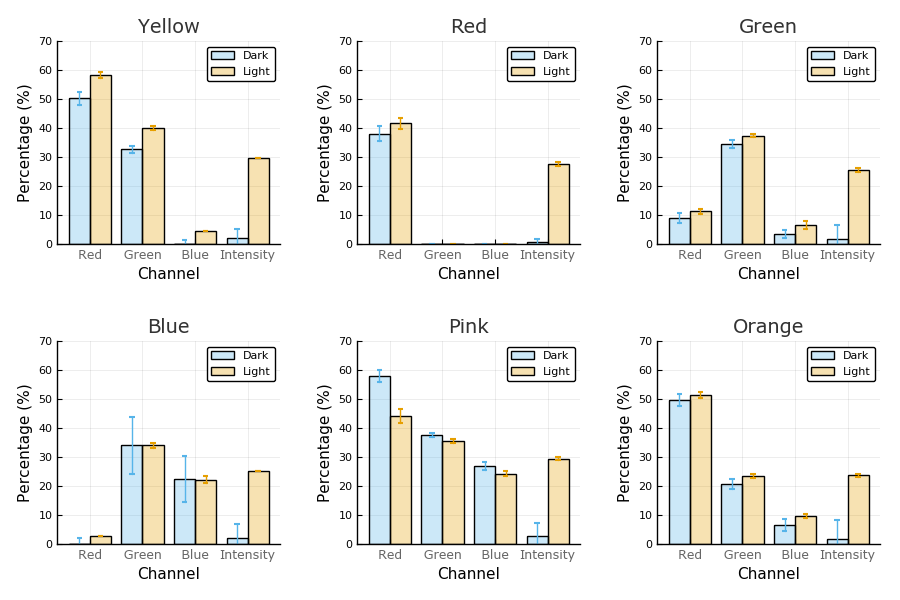

In [18]:
plot((analyzecolor(datagroup) for datagroup in groupby(color_data, :PColor))...,
#     legend=true,
    xtickfont=font(9, "Verdana", colorant"gray40"),
    titlefont=font("Verdana", colorant"gray20"),
    margin=5mm,
    size=(900,600))
# a, b = color_data[1, [:Red, :Green]]